In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

(11, 15)

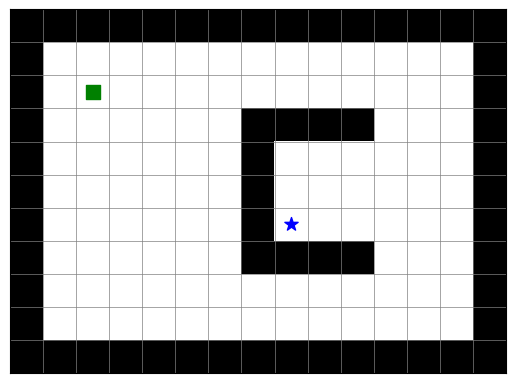

In [13]:
maze = np.zeros((9, 13))


# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (6, 8)

pad = np.ones(np.array(maze.shape) + 2)
pad[1:-1, 1:-1] = maze
maze = pad


# define goal (we abuse function scoping a bit here, later we will change the goal, which will automatically change the goal in our actor critic as well)
goal = (2, 2)
goal_state = goal[0]*maze.shape[1] + goal[1]
goal_value = 10

def plot_maze(maze, start:None, end=None):
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)
    plt.scatter(start[1],start[0],marker='*',color='blue',s=100)
    plt.scatter(end[1],end[0],marker='s',color='green',s=100)
    plt.xticks([])
    plt.yticks([])

plot_maze(maze, start, goal)
maze.shape

In [14]:
def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    transitions = np.zeros((maze.size, maze.size))

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            # check if state is valid
            if maze[i, j] == 0:
                # iterate over all possible moves
                for move in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    new_i, new_j = i + move[0], j + move[1]
                    # check if new state is valid
                    if new_i >= 0 and new_i < maze.shape[0] and new_j >= 0 and new_j < maze.shape[1] and maze[new_i, new_j] == 0:
                        transitions[i*maze.shape[1] + j, new_i*maze.shape[1] + new_j] = 1
    
    # normalize transitions
    transitions /= transitions.sum(axis=1, keepdims=True)

    # remove NaNs
    transitions[np.isnan(transitions)] = 0

    return transitions

transitions = compute_transition_matrix(maze)

/tmp/ipykernel_5637/2572442783.py:21: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True)


In [15]:
def analytical_sr(transitions: np.ndarray, gamma: float) -> np.ndarray:
    """do the closed form solution for successor representation. Equal to the infinite product. 

    Args:
        transitions (np.ndarray): transition matrix from state to state
        gamma (float): discount factor

    Returns:
        np.ndarray: updated transition matrix
    """
    return np.linalg.inv(np.eye(transitions.shape[0]) - gamma * transitions.T)

i, j = start
# compute the SR for all states, based on the transition matrix
# note that we use a lower discounting here, to keep the SR more local
analytical_state_repr = analytical_sr(transitions, 0.8)

In [9]:
grid_indices = np.stack(np.meshgrid(np.arange(11), np.arange(15))).reshape(2,-1).T

# Part 1:

program an actor critic algorithm to navigate the maze, using a table of action propensities M with softmax action selection as actor, and a learned state-value function as critic


In [55]:
from tqdm import tqdm


def softmax(x: np.ndarray) -> np.ndarray:
    exp = np.exp(x)
    return exp / exp.sum()


def normal_start() -> int:
    """returns the index of the start state

    Returns:
        int: state index
    """
    # suggested encoding of 2D location onto states
    state = state2int(np.array(start))
    return state


def int2state(state_integer: np.ndarray) -> np.ndarray:
    """convert an array of integer into an array of 2D coordinates

    Args:
        state_integer (np.ndarray): integer array (n_samples,)

    Returns:
        np.ndarray: coordinate array (n_samples, 2)
    """
    row = state_integer // maze.shape[1]
    column = state_integer - (maze.shape[1] * row)
    coords = np.stack([row, column]).T
    return coords


def state2int(state: np.ndarray) -> np.ndarray:
    """convert 2D coordinates to integer array

    Args:
        state (np.ndarray): (2, n_samples)

    Returns:
        np.ndarray: (n_samples,)
    """
    state = state[0] * maze.shape[1] + state[1]
    return state

def get_valid_action_mask(state: np.ndarray) -> np.ndarray:
    """returns binary mask which action you can take and which not.
    1 means you can move there 0 you can not

    Args:
        state (np.ndarray): 2D state coordinates (x, y)

    Returns:
        np.ndarray: (4,) binary mask
    """
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype=int)
    move_options = state[None] + possible_moves
    # remove those moves which run into a barrier
    move_options = 1 - maze[*move_options.T]
    return move_options


def actor_critic(
    state_representation,
    n_steps,
    alpha,
    gamma,
    n_episodes,
    update_sr=False,
    start_func=normal_start,
    v_init=0,
):
    # implement the actor-critic algorithm to learn to navigate the maze
    # state_representation is a matrix of size n_states by n_states, giving us the representation for each, which is either a 1-hot vector
    # # (so e.g. state_representation[15] is a vector of size n_states which is 0 everywhere, except 1 at index 15), or the SR for each state
    # n_steps is the number of actions in each episode before it gets cut off, an episode also ends when the agent reaches the goal
    # alpha and gamma are the learning rate and discount factor respectively
    # n_episodes is the number of episodes to train the agent
    # update_sr is for exercise part 3, when you want to update the SR after each episode
    # start_func allows you to specify a different starting state, if desired
    n_states = len(state_representation)
    # initialize M-table... table of action properties -> those are the base for the action for each state -> (base of Q function)
    M = np.ones((n_states, 4), dtype=float) / 4
    # M = np.ones_like(state_representation, dtype=float)

    # initialize state-value function
    V_weights = v_init * np.ones(n_states)

    earned_rewards = np.zeros(n_episodes)
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype=int)
    
    # iterate over episodes
    for episode_idx in tqdm(range(n_episodes)):
        # initializations
        trajectory = np.zeros(n_steps, dtype=int)

        state = start_func()
        discount = 1
        # go until goal is reached
        for t in range(n_steps):
            trajectory[t] = state
            # act and learn (update both M and V_weights)
            state_coords = int2state(state)
            action_mask = get_valid_action_mask(state_coords)

            action_logits = M[state]
            action_logits[action_mask == 0] = -np.inf
            action_distr = softmax(action_logits)

            action = possible_moves[np.random.choice(4, p=action_distr)]
            next_state_coords = state_coords + action
            next_state = state2int(next_state_coords)

            reward = 0
            current_value = state_representation[state] @ V_weights
            next_value = state_representation[next_state] @ V_weights
            if next_state == goal_state:
                reward = goal_value
                earned_rewards[episode_idx] += discount * reward
                next_value = 0
            
            delta = reward + gamma * next_value - current_value

            V_weights += alpha * delta * state_representation[state]
            log_grad = -action_distr
            log_grad[action] += 1
            M[state] += alpha * discount * delta * log_grad 

            # check if goal is reached
            if next_state == goal_state:
                trajectory = trajectory[: t + 1]
                break

            state = next_state
            discount *= gamma

        if update_sr:
            # state_representation = learn_from_traj(
            #     state_representation, trajectory, gamma, alpha
            # )
            pass

    return M, V_weights, earned_rewards

In [ ]:
# One part to the solution of exercise part 3, if you want to update the SR after each episode
def learn_from_traj(succ_repr, trajectory, gamma=0.98, alpha=0.05):
    # Write a function to update a given successor representation (for the state at which the trajectory starts) using an example trajectory
    # using discount factor gamma and learning rate alpha

    observed = np.zeros_like(succ_repr)

    for i, state in enumerate(trajectory):
        observed[state] += gamma ** i

    succ_repr += alpha * (observed - succ_repr)

    # return the updated successor representation
    return succ_repr

# Part 1

100%|██████████| 1000/1000 [00:15<00:00, 65.62it/s]


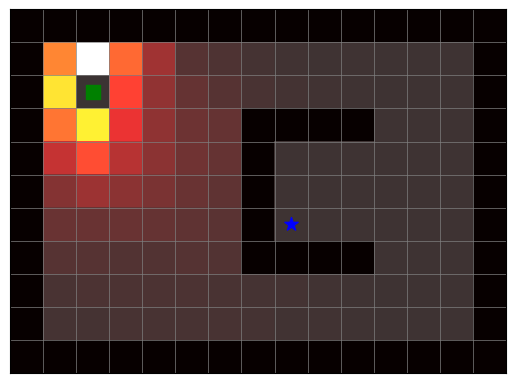

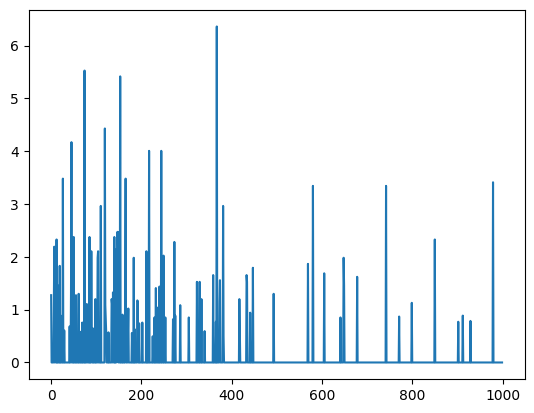

In [57]:
state_repr = np.eye(len(transitions))
M, V, earned_rewards = actor_critic(state_repr, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000)
# plot state-value function
plot_maze(maze, start, goal)
plt.imshow(V.reshape(maze.shape), cmap='hot', alpha=0.8)
plt.show()

plt.plot(earned_rewards)
plt.show()



# Part 2, now the same for an SR representation


/tmp/ipykernel_5753/2572442783.py:21: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True)
100%|██████████| 1000/1000 [00:10<00:00, 93.83it/s]


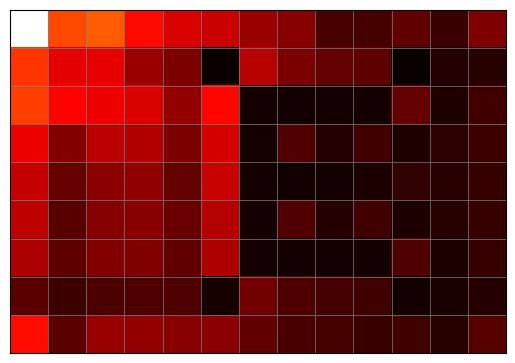

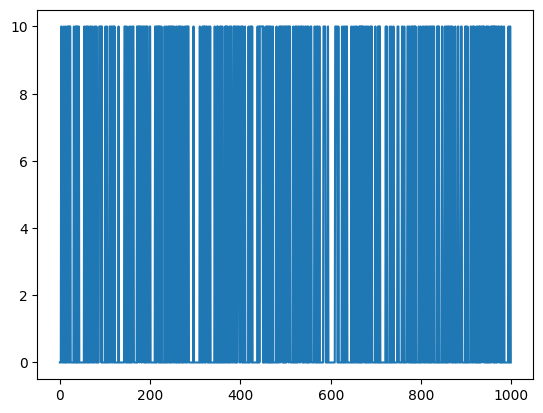

In [9]:
M, V, earned_rewards = actor_critic(analytical_state_repr, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000)

# plot state-value function
plot_maze(maze)
plt.imshow(V.reshape((9, 13)), cmap='hot')
plt.show()

plt.plot(earned_rewards)
plt.show()


# Part 3

In [10]:
type(np.float64(43))

numpy.float64

In [11]:
def random_start():
    # define yourself a function to return a random (non-wall) starting state to pass into the actor_critic function

    mask = transitions.sum(axis=1)
    mask[mask == 0] = -np.inf
    p = softmax(mask)
    return np.random.choice(len(p), p=p)


state_repr = np.eye(len(transitions))
M, V, earned_rewards = actor_critic(
    analytical_state_repr,
    300,
    0.05,
    0.99,
    1000,
    update_sr=True,
    start_func=random_start,
)
# plot state-value function
plot_maze(maze)
plt.imshow(V.reshape((9, 13)), cmap="hot")
plt.show()

plt.plot(earned_rewards)
plt.show()

/tmp/ipykernel_5753/2572442783.py:21: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True)
 26%|██▌       | 261/1000 [00:02<00:05, 134.12it/s]/tmp/ipykernel_5753/1071561794.py:61: RuntimeWarning: overflow encountered in matmul
  next_value = state_representation[next_state] @ V_weights if next_state != goal_state else 0
/tmp/ipykernel_5753/1071561794.py:72: RuntimeWarning: invalid value encountered in multiply
  M = M + alpha * delta * np.log(action)[None]
 27%|██▋       | 272/1000 [00:02<00:05, 123.69it/s]


ValueError: probabilities contain NaN

plot the SR of some states after this learning, also anything else you want

In [12]:
# plot the SR of some states after this learning, also anything else you want
TODO

NameError: name 'TODO' is not defined

# Part 4

In [ ]:
TODO
goal = (5, 5)
goal_state = goal[0]*maze.shape[1] + goal[1]
for i in range(20):

    # run with random walk SR
    M, V, earned_rewards_clamped = actor_critic(TODO, 300, 0.05, 0.99, 400)
    TODO

    # run with updated SR
    M, V, earned_rewards_relearned = actor_critic(TODO, 300, 0.05, 0.99, 400)
    TODO

plot the performance averages of the two types of learners


# Part 5

In [ ]:
# reset goal
goal = (1, 1)
goal_state = goal[0]*maze.shape[1] + goal[1]

# run some learners with different value weight w initializations

TODO
for v_inits in [TODO]:
    TODO
    for i in range(12):

        M, V, earned_rewards = actor_critic(TODO, 300, 0.05, 0.99, 400)
        TODO
        M, V, earned_rewards = actor_critic(TODO, 300, 0.05, 0.99, 400)
        TODO

# plot the resulting learning curves